In [2]:
import pandas as pd

# Load the dataset (modify the filename accordingly)
df = pd.read_csv("C:/Users/beste/Downloads/ibtracs.NI.list.v04r01.csv")

# Remove the first row with units
df = df.iloc[1:].reset_index(drop=True)

# Select relevant columns
columns_needed = ["SID", "ISO_TIME", "LAT", "LON", "STORM_SPEED", "STORM_DIR"]
df = df[columns_needed]

# Rename columns for consistency
df.columns = ["storm_id", "timestamp", "latitude", "longitude", "storm_speed", "storm_direction"]

# Convert timestamp column to datetime format
df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")

# Convert latitude and longitude to numeric values
df["latitude"] = pd.to_numeric(df["latitude"], errors="coerce")
df["longitude"] = pd.to_numeric(df["longitude"], errors="coerce")

# Sort by storm ID and timestamp
df = df.sort_values(by=["storm_id", "timestamp"])

# Check for missing values
missing_values = df.isnull().sum()

# Display the cleaned dataset and missing values summary
df.head(), missing_values


C:\Users\beste\AppData\Local\Temp\ipykernel_36012\1273305794.py:4: DtypeWarning: Columns (1,2,8,9,14,172,173) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("C:/Users/beste/Downloads/ibtracs.NI.list.v04r01.csv")


(        storm_id           timestamp  latitude  longitude storm_speed  \
 0  1842298N11080 1842-10-25 03:00:00      10.9       80.3           9   
 1  1842298N11080 1842-10-25 06:00:00      10.9       79.8           9   
 2  1842298N11080 1842-10-25 09:00:00      10.8       79.4           9   
 3  1842298N11080 1842-10-25 12:00:00      10.8       78.9           9   
 4  1842298N11080 1842-10-25 15:00:00      10.8       78.4           9   
 
   storm_direction  
 0             265  
 1             265  
 2             265  
 3             265  
 4             270  ,
 storm_id           0
 timestamp          0
 latitude           0
 longitude          0
 storm_speed        0
 storm_direction    0
 dtype: int64)

In [8]:
df

,storm_id,timestamp,latitude,longitude,storm_speed,storm_direction
0,1842298N11080,1842-10-25 03:00:00,10.9,80.3,9,265
1,1842298N11080,1842-10-25 06:00:00,10.9,79.8,9,265
2,1842298N11080,1842-10-25 09:00:00,10.8,79.4,9,265
3,1842298N11080,1842-10-25 12:00:00,10.8,78.9,9,265
4,1842298N11080,1842-10-25 15:00:00,10.8,78.4,9,270
...,...,...,...,...,...,...
62043,2024335N12082,2024-12-03 12:00:00,13.2,72.8,13,270
62044,2024335N12082,2024-12-03 15:00:00,13.2,72.2,10,260
62045,2024335N12082,2024-12-03 18:00:00,13.0,71.8,8,245
62046,2024335N12082,2024-12-03 21:00:00,12.8,71.5,8,230


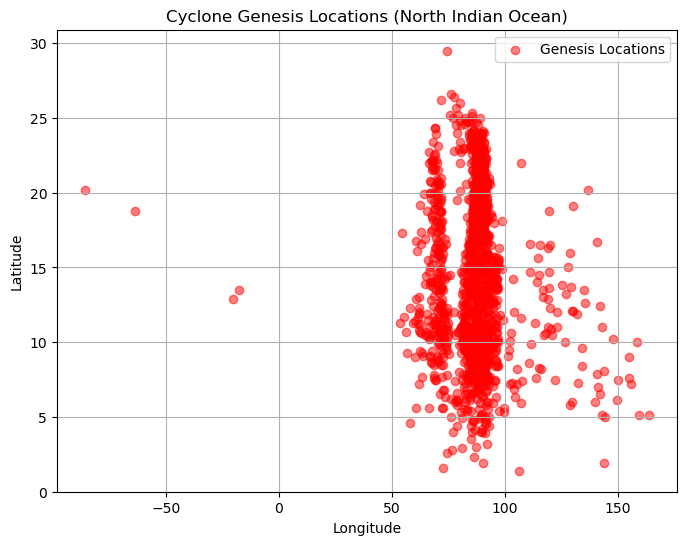

In [7]:
import matplotlib.pyplot as plt

# Extract genesis points (first recorded location for each storm)
genesis_df = df.groupby("storm_id").first().reset_index()

# Plot genesis locations
plt.figure(figsize=(8, 6))
plt.scatter(genesis_df["longitude"], genesis_df["latitude"], alpha=0.5, c="red", label="Genesis Locations")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Cyclone Genesis Locations (North Indian Ocean)")
plt.legend()
plt.grid(True)
plt.show()


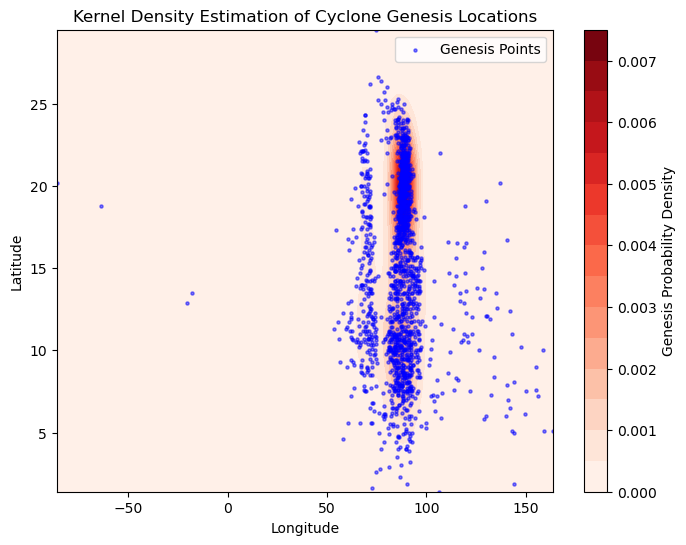

In [8]:
import numpy as np
import seaborn as sns
from scipy.stats import gaussian_kde

# Extract genesis locations as numpy arrays
x = genesis_df["longitude"].values
y = genesis_df["latitude"].values

# Apply KDE (bandwidth automatically determined)
xy = np.vstack([x, y])
kde = gaussian_kde(xy, bw_method="scott")  # 'scott' is an automatic bandwidth estimator

# Generate grid for density estimation
x_grid, y_grid = np.meshgrid(np.linspace(min(x), max(x), 100),
                             np.linspace(min(y), max(y), 100))
positions = np.vstack([x_grid.ravel(), y_grid.ravel()])
density = kde(positions).reshape(x_grid.shape)

# Plot the KDE heatmap
plt.figure(figsize=(8, 6))
plt.contourf(x_grid, y_grid, density, cmap="Reds", levels=15)
plt.colorbar(label="Genesis Probability Density")
plt.scatter(x, y, s=5, c="blue", alpha=0.5, label="Genesis Points")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Kernel Density Estimation of Cyclone Genesis Locations")
plt.legend()
plt.show()


In [9]:
# Compute 6-hour displacements
df["lat_disp"] = df.groupby("storm_id")["latitude"].diff()
df["lon_disp"] = df.groupby("storm_id")["longitude"].diff()

# Drop first rows (NaN displacements for genesis points)
df_displacements = df.dropna(subset=["lat_disp", "lon_disp"])

# Compute mean & variance of displacements
mean_lat_disp = df_displacements["lat_disp"].mean()
mean_lon_disp = df_displacements["lon_disp"].mean()
var_lat_disp = df_displacements["lat_disp"].var()
var_lon_disp = df_displacements["lon_disp"].var()

print(f"Mean Latitude Displacement: {mean_lat_disp:.4f}")
print(f"Mean Longitude Displacement: {mean_lon_disp:.4f}")
print(f"Variance in Latitude Displacement: {var_lat_disp:.4f}")
print(f"Variance in Longitude Displacement: {var_lon_disp:.4f}")


Mean Latitude Displacement: 0.1562
Mean Longitude Displacement: -0.1972
Variance in Latitude Displacement: 0.0342
Variance in Longitude Displacement: 0.1189


In [10]:
print('penis')

penis


In [22]:
import statsmodels.api as sm

# Fit AR(1) model for latitude displacement
lat_disp_lag = df_displacements["lat_disp"].shift(1).drop(1)  # Previous step
lat_disp_current = df_displacements["lat_disp"].drop(1)

lat_model = sm.OLS(lat_disp_current, sm.add_constant(lat_disp_lag)).fit()
phi_lat = lat_model.params[1]  # AR(1) coefficient for latitude

# Fit AR(1) model for longitude displacement
lon_disp_lag = df_displacements["lon_disp"].shift(1).drop(1)
lon_disp_current = df_displacements["lon_disp"].drop(1)

lon_model = sm.OLS(lon_disp_current, sm.add_constant(lon_disp_lag)).fit()
phi_lon = lon_model.params[1]  # AR(1) coefficient for longitude

print(f"AR(1) Coefficient for Latitude: {phi_lat:.4f}")
print(f"AR(1) Coefficient for Longitude: {phi_lon:.4f}")


AR(1) Coefficient for Latitude: 0.8110
AR(1) Coefficient for Longitude: 0.9080


C:\Users\beste\AppData\Local\Temp\ipykernel_36012\1209842446.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  phi_lat = lat_model.params[1]  # AR(1) coefficient for latitude
C:\Users\beste\AppData\Local\Temp\ipykernel_36012\1209842446.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  phi_lon = lon_model.params[1]  # AR(1) coefficient for longitude


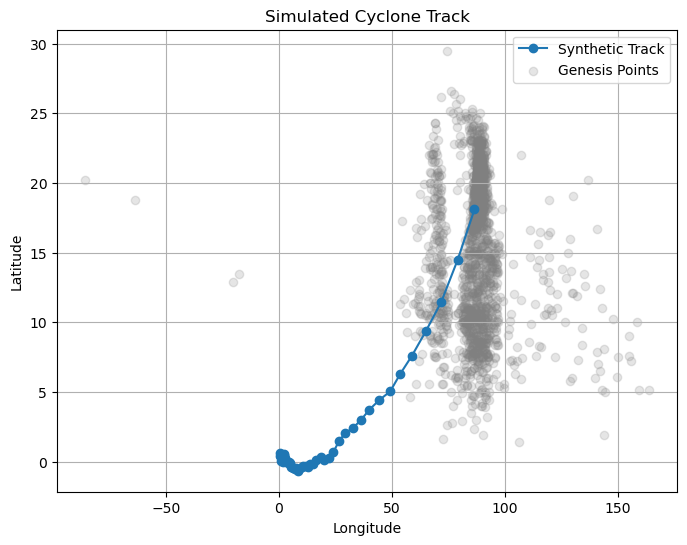

In [24]:
import numpy as np

def simulate_cyclone(n_steps=50):
    """Simulate a synthetic cyclone track using AR(1) movement."""
    
    # Start from a random genesis point
    start = genesis_df.sample(1)
    lat, lon = start["latitude"].values[0], start["longitude"].values[0]
    
    # Store track points
    track = [(lat, lon)]
    
    # Simulate movement step by step
    for _ in range(n_steps):
        # Apply AR(1) update
        lat = phi_lat * lat + np.random.normal(scale=np.sqrt(var_lat_disp))
        lon = phi_lon * lon + np.random.normal(scale=np.sqrt(var_lon_disp))
        
        track.append((lat, lon))
    
    return np.array(track)

# Generate a synthetic cyclone track
track = simulate_cyclone()

# Plot the simulated track
plt.figure(figsize=(8, 6))
plt.plot(track[:, 1], track[:, 0], marker="o", linestyle="-", label="Synthetic Track")
plt.scatter(genesis_df["longitude"], genesis_df["latitude"], alpha=0.2, c="gray", label="Genesis Points")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Simulated Cyclone Track")
plt.legend()
plt.grid(True)
plt.show()


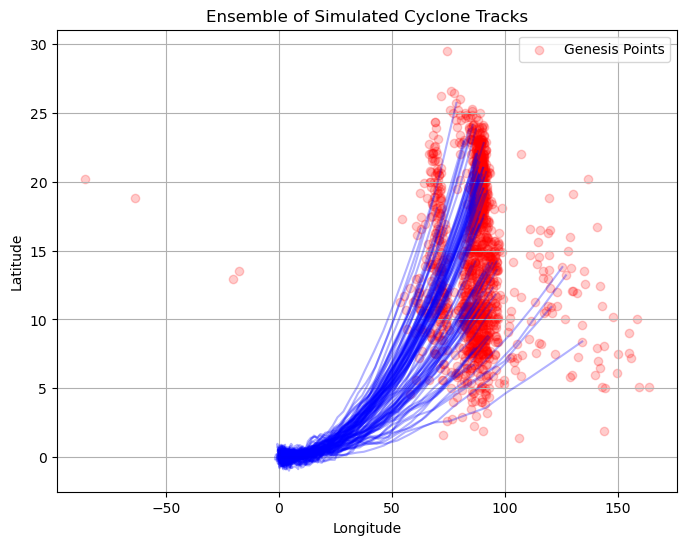

In [36]:
def simulate_multiple_cyclones(n_cyclones=100, n_steps=50):
    """Simulate multiple synthetic cyclone tracks."""
    all_tracks = []
    
    for _ in range(n_cyclones):
        track = simulate_cyclone(n_steps)
        all_tracks.append(track)
    
    return all_tracks

# Generate 100 synthetic cyclone tracks
tracks = simulate_multiple_cyclones(n_cyclones=100, n_steps=50)

# Plot all simulated tracks
plt.figure(figsize=(8, 6))
for track in tracks:
    plt.plot(track[:, 1], track[:, 0], alpha=0.3, linestyle="-", color="blue")

# Overlay historical genesis points
plt.scatter(genesis_df["longitude"], genesis_df["latitude"], alpha=0.2, c="red", label="Genesis Points")

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Ensemble of Simulated Cyclone Tracks")
plt.legend()
plt.grid(True)
plt.show()
